In [1]:
# Celda 1: Importaciones
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE  # Para la visualización 2D estilo Paper

# Configuración de estilo para las gráficas
sns.set(style="whitegrid")
%matplotlib inline

# Configuración
INPUT_FILE = "embeddings_dataset.json" # Asegúrate que este archivo esté junto al notebook
K_NEIGHBORS = 3  # El Paper sugiere k=3 para datasets pequeños

In [2]:
# Celda 2: Carga y Estructuración de Datos
try:
    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        raw_data = json.load(f)
    print(f"✅ Dataset cargado: {len(raw_data)} archivos.")
except FileNotFoundError:
    print(f"❌ Error: No se encuentra '{INPUT_FILE}'. Ejecuta primero el script de generación.")

# 1. Obtener modelos disponibles y etiquetas
available_models = list(raw_data[0]['embeddings'].keys())
all_labels = [item['label'] for item in raw_data]

# 2. Codificar etiquetas (De 'Singleton' a números 0, 1, 2...)
le = LabelEncoder()
y_encoded = le.fit_transform(all_labels)
class_names = le.classes_

print(f"🤖 Modelos encontrados: {available_models}")
print(f"🏷️ Clases detectadas ({len(class_names)}): {class_names}")

# 3. Estructurar datos por modelo
models_data = {}

for model_name in available_models:
    vectors = []
    labels_indices = []
    
    for idx, item in enumerate(raw_data):
        if model_name in item['embeddings']:
            vectors.append(item['embeddings'][model_name])
            labels_indices.append(idx)
    
    if vectors:
        models_data[model_name] = {
            'X': np.array(vectors),
            'y': y_encoded[labels_indices]
        }
        print(f"   -> {model_name}: {len(vectors)} vectores listos.")

✅ Dataset cargado: 467 archivos.
🤖 Modelos encontrados: ['nomic-embed-text:latest', 'qwen2.5-coder:7b', 'llama3.2:latest']
🏷️ Clases detectadas (23): ['AbstractFactory' 'Adapter' 'Bridge' 'Builder' 'ChainOfResponsibility'
 'Command' 'Composite' 'Decorator' 'Facade' 'Factory' 'Flyweight'
 'Interpreter' 'Iterator' 'Mediator' 'Memento' 'Observer' 'Prototype'
 'Proxy' 'Singleton' 'State' 'Strategy' 'TemplateMethod' 'Visitor']
   -> nomic-embed-text:latest: 465 vectores listos.
   -> qwen2.5-coder:7b: 467 vectores listos.
   -> llama3.2:latest: 467 vectores listos.


In [6]:
# Celda 3: Funciones Core (CORREGIDA)
def evaluate_model_knn(X, y, k=3):
    """
    Entrena k-NN y devuelve las predicciones y métricas.
    """
    # Split Estratificado (intenta mantener la proporción, pero puede fallar en clases con n=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # K-NN con distancia Euclidiana
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    # --- CORRECCIÓN DEL ERROR ---
    # Definimos explícitamente que queremos reporte de TODAS las clases (0, 1, 2... 22)
    # aunque algunas no aparezcan en el test set.
    all_possible_labels = np.arange(len(class_names))
    
    report = classification_report(
        y_test, 
        y_pred, 
        labels=all_possible_labels, # <--- ESTA LÍNEA ARREGLA EL ERROR
        target_names=class_names, 
        output_dict=True,
        zero_division=0 # Evita warnings si una clase falta por completo
    )
    
    # Recalculamos F1
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return f1, report, y_test, y_pred

def plot_cm(y_true, y_pred, classes, title):
    """Dibuja una matriz de confusión bonita"""
    # También aseguramos que la matriz de confusión use todas las etiquetas
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    
    plt.figure(figsize=(12, 10)) # Un poco más grande para que quepan 23 clases
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=15)
    plt.ylabel('Verdad (Ground Truth)')
    plt.xlabel('Predicción del Modelo')
    plt.xticks(rotation=45, ha='right') # Rotar nombres para que se lean mejor
    plt.tight_layout()
    plt.show()

In [7]:
# Celda 4: Ejecución y Reporte Numérico
results_summary = {}
predictions_data = {} # Guardamos datos para graficar luego

print(f"📊 RESULTADOS DE CLASIFICACIÓN (k={K_NEIGHBORS})\n")

for model_name, data in models_data.items():
    print("="*60)
    print(f"MODELO: {model_name}")
    print("="*60)
    
    f1, report, y_test, y_pred = evaluate_model_knn(data['X'], data['y'], k=K_NEIGHBORS)
    
    # Guardar para gráficas
    results_summary[model_name] = f1
    predictions_data[model_name] = (y_test, y_pred)
    
    # Imprimir reporte formateado
    df_report = pd.DataFrame(report).transpose()
    print(df_report.iloc[:-3, :3]) # Mostramos precision/recall/f1 por clase
    print(f"\n⭐ F1-Score Global (Weighted): {f1:.4f}\n")

📊 RESULTADOS DE CLASIFICACIÓN (k=3)

MODELO: nomic-embed-text:latest
                       precision    recall  f1-score
AbstractFactory         0.571429  0.800000  0.666667
Adapter                 0.250000  0.400000  0.307692
Bridge                  0.285714  0.666667  0.400000
Builder                 0.230769  0.428571  0.300000
ChainOfResponsibility   0.000000  0.000000  0.000000
Command                 0.416667  0.555556  0.476190
Composite               0.000000  0.000000  0.000000
Decorator               0.500000  0.428571  0.461538
Facade                  0.666667  0.500000  0.571429
Factory                 0.000000  0.000000  0.000000
Flyweight               0.250000  0.333333  0.285714
Interpreter             0.000000  0.000000  0.000000
Iterator                1.000000  0.250000  0.400000
Mediator                0.666667  0.666667  0.666667
Memento                 1.000000  0.250000  0.400000
Observer                0.600000  0.500000  0.545455
Prototype               0.5000

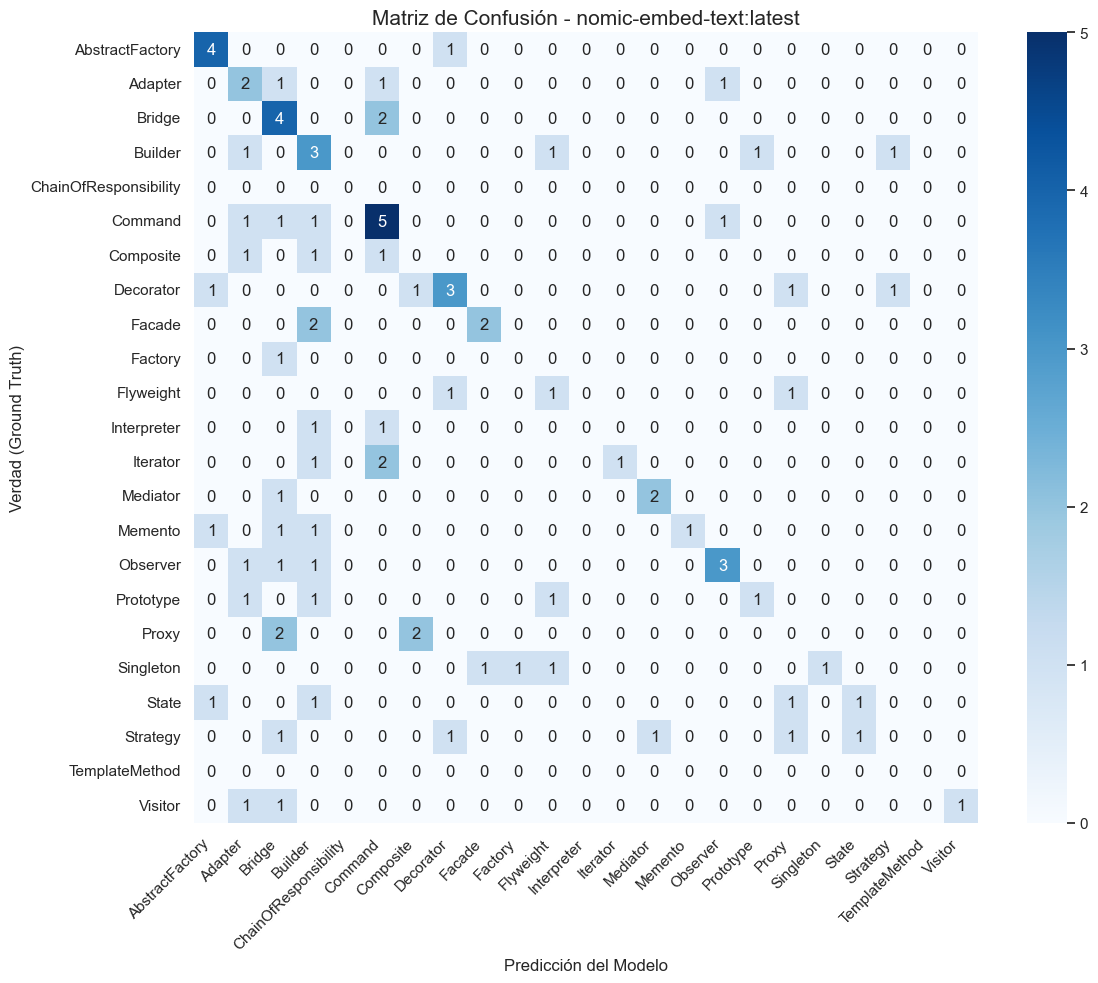

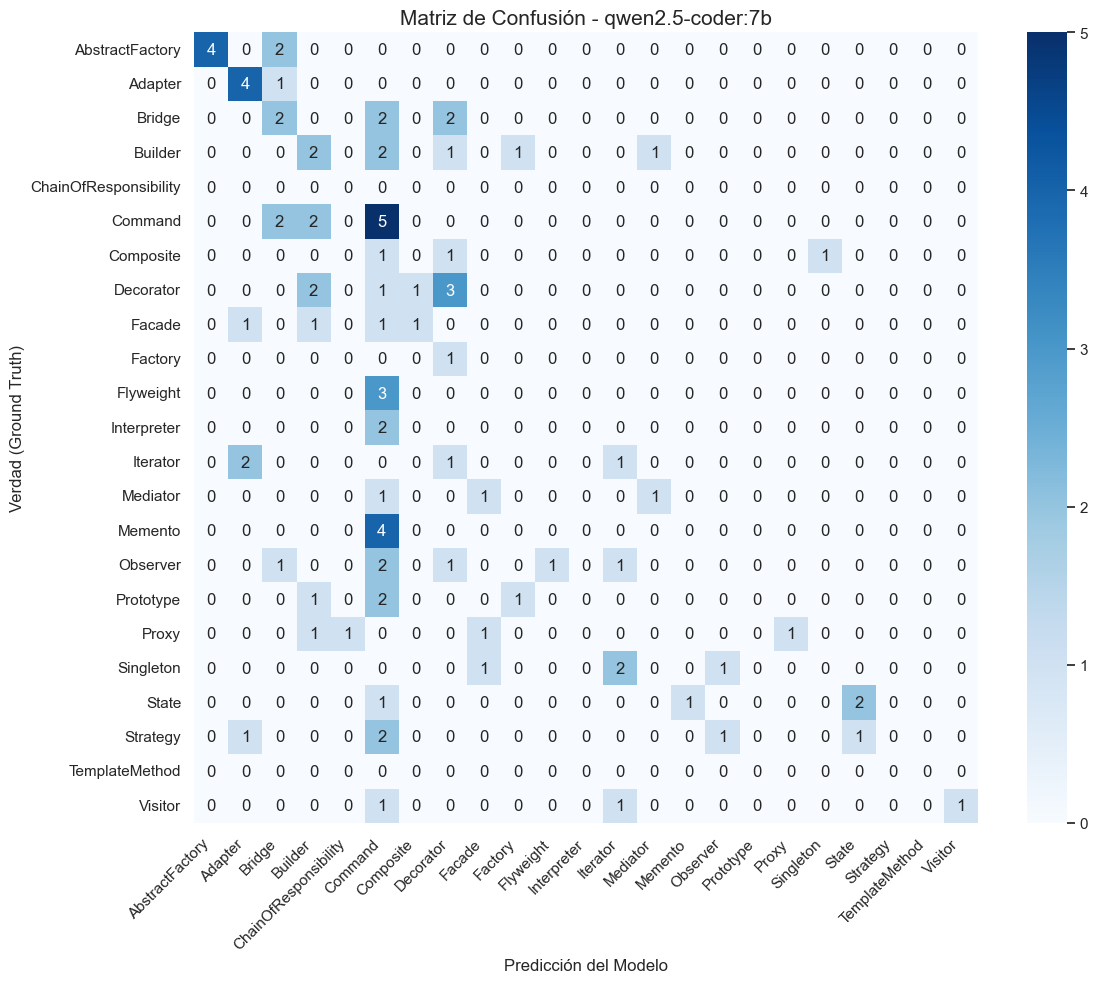

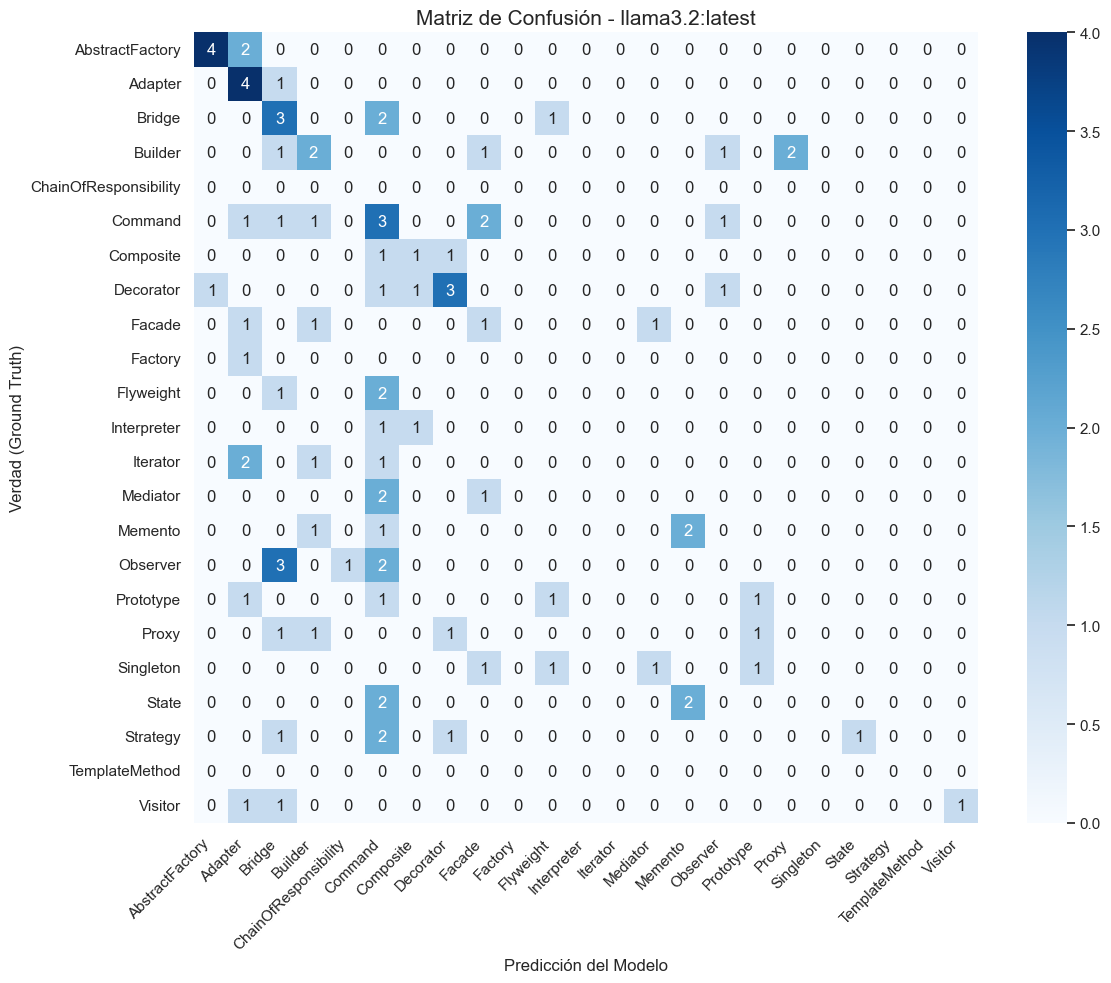

In [8]:
# Celda 5: Matrices de Confusión
for model_name, (y_test, y_pred) in predictions_data.items():
    plot_cm(y_test, y_pred, class_names, f"Matriz de Confusión - {model_name}")

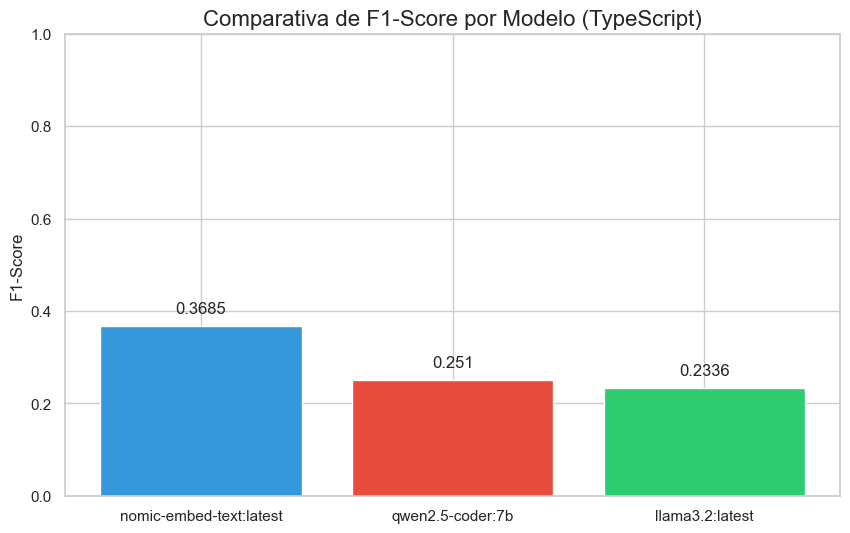

In [9]:
# Celda 6: Comparativa de Rendimiento
plt.figure(figsize=(10, 6))
bars = plt.bar(results_summary.keys(), results_summary.values(), color=['#3498db', '#e74c3c', '#2ecc71'])

plt.title('Comparativa de F1-Score por Modelo (TypeScript)', fontsize=16)
plt.ylabel('F1-Score', fontsize=12)
plt.ylim(0, 1.0)

# Poner el número encima de la barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 4), ha='center', va='bottom', fontsize=12)

plt.show()

🗺️ Generando mapas t-SNE para 3 modelos...

   ... procesando nomic-embed-text:latest ...


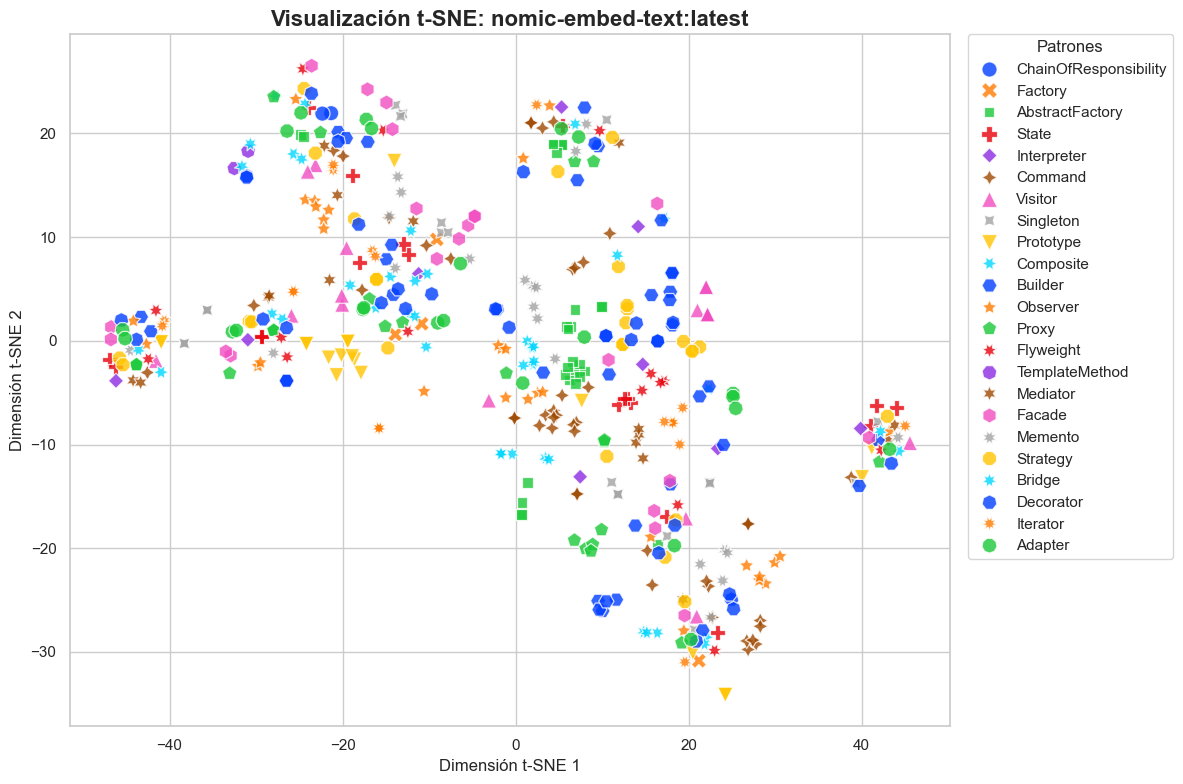

   ... procesando qwen2.5-coder:7b ...


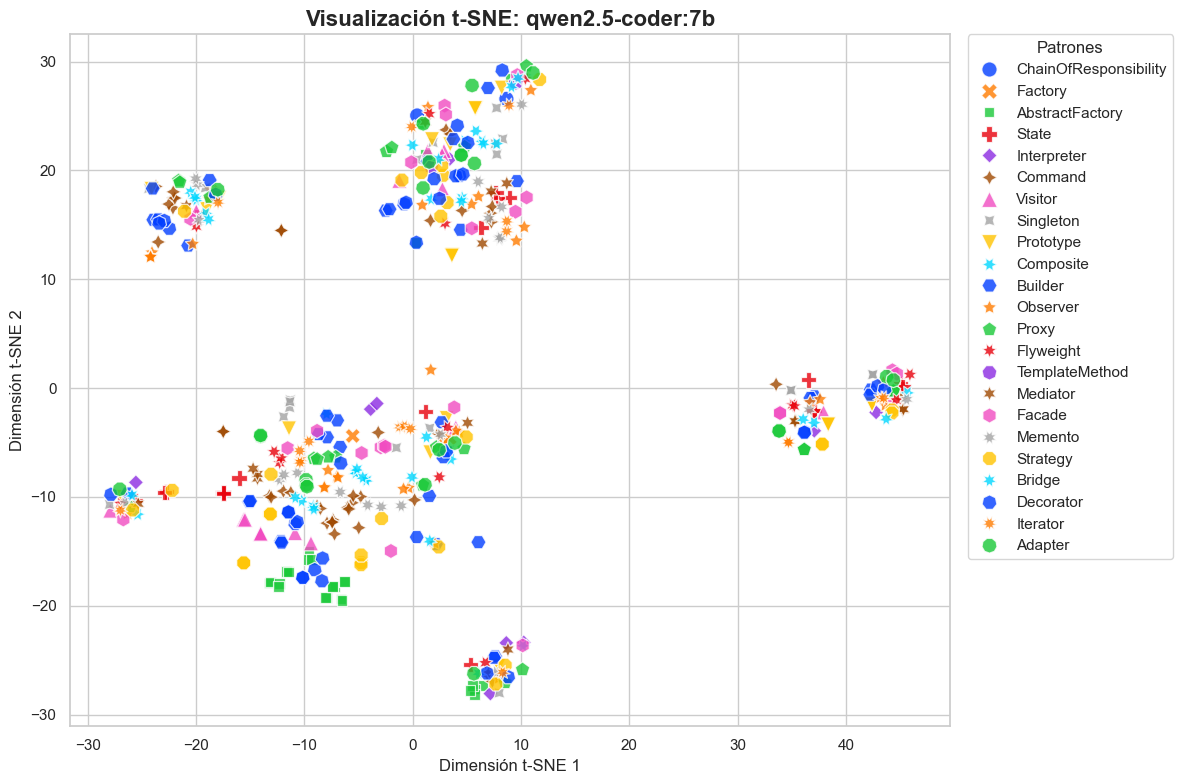

   ... procesando llama3.2:latest ...


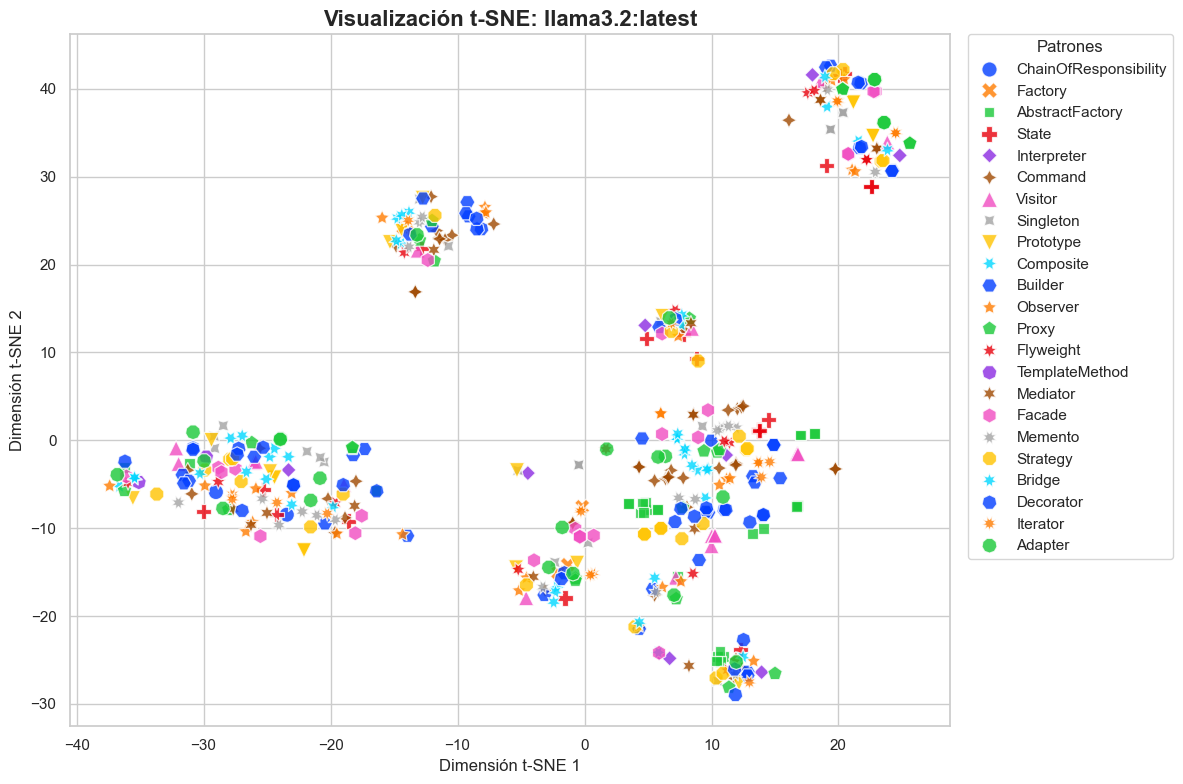


✅ Visualización completada.


In [11]:
# Celda 7: Generación de t-SNE para CADA modelo individualmente
from sklearn.manifold import TSNE

print(f"🗺️ Generando mapas t-SNE para {len(models_data)} modelos...\n")

# Iteramos sobre cada modelo guardado en el diccionario
for model_name, data in models_data.items():
    print(f"   ... procesando {model_name} ...")
    
    X = data['X']
    y = data['y']
    
    # 1. Calcular t-SNE
    # Perplexity: ajustamos dinámicamente si hay pocos datos para evitar errores
    perplex_val = min(30, len(X) - 1) 
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplex_val, init='pca', learning_rate='auto')
    X_embedded = tsne.fit_transform(X)
    
    # 2. Crear DataFrame para la gráfica
    df_tsne = pd.DataFrame(X_embedded, columns=['Dim 1', 'Dim 2'])
    # Convertimos los números de etiqueta (0,1,2) a nombres reales (Singleton, Factory...)
    df_tsne['Patrón'] = class_names[y] 
    
    # 3. Graficar con Seaborn
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df_tsne, 
        x='Dim 1', 
        y='Dim 2', 
        hue='Patrón',     # Color por patrón
        style='Patrón',   # Forma del punto por patrón (ayuda a distinguir)
        palette='bright', # Colores vivos para diferenciar mejor
        s=120,            # Tamaño del punto
        alpha=0.8         # Transparencia
    )
    
    plt.title(f"Visualización t-SNE: {model_name}", fontsize=16, fontweight='bold')
    plt.xlabel("Dimensión t-SNE 1")
    plt.ylabel("Dimensión t-SNE 2")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title="Patrones")
    plt.tight_layout()
    plt.show() # Renderiza la gráfica actual antes de pasar a la siguiente

print("\n✅ Visualización completada.")

📉 Orden de Patrones (por frecuencia):
   - Command: 46 archivos
   - Decorator: 34 archivos
   - Builder: 33 archivos
   - Observer: 30 archivos
   - Bridge: 28 archivos
   - AbstractFactory: 27 archivos
   - Strategy: 27 archivos
   - Adapter: 23 archivos
   - Proxy: 22 archivos
   - Facade: 21 archivos
   - Memento: 21 archivos
   - Singleton: 20 archivos
   - Prototype: 19 archivos
   - State: 19 archivos
   - Iterator: 18 archivos
   - Visitor: 17 archivos
   - Flyweight: 15 archivos
   - Mediator: 15 archivos
   - Composite: 13 archivos
   - Interpreter: 9 archivos
   - Factory: 4 archivos
   - ChainOfResponsibility: 2 archivos
   - TemplateMethod: 2 archivos

🖼️ Generando visualizaciones (Grupos de 4 patrones)...



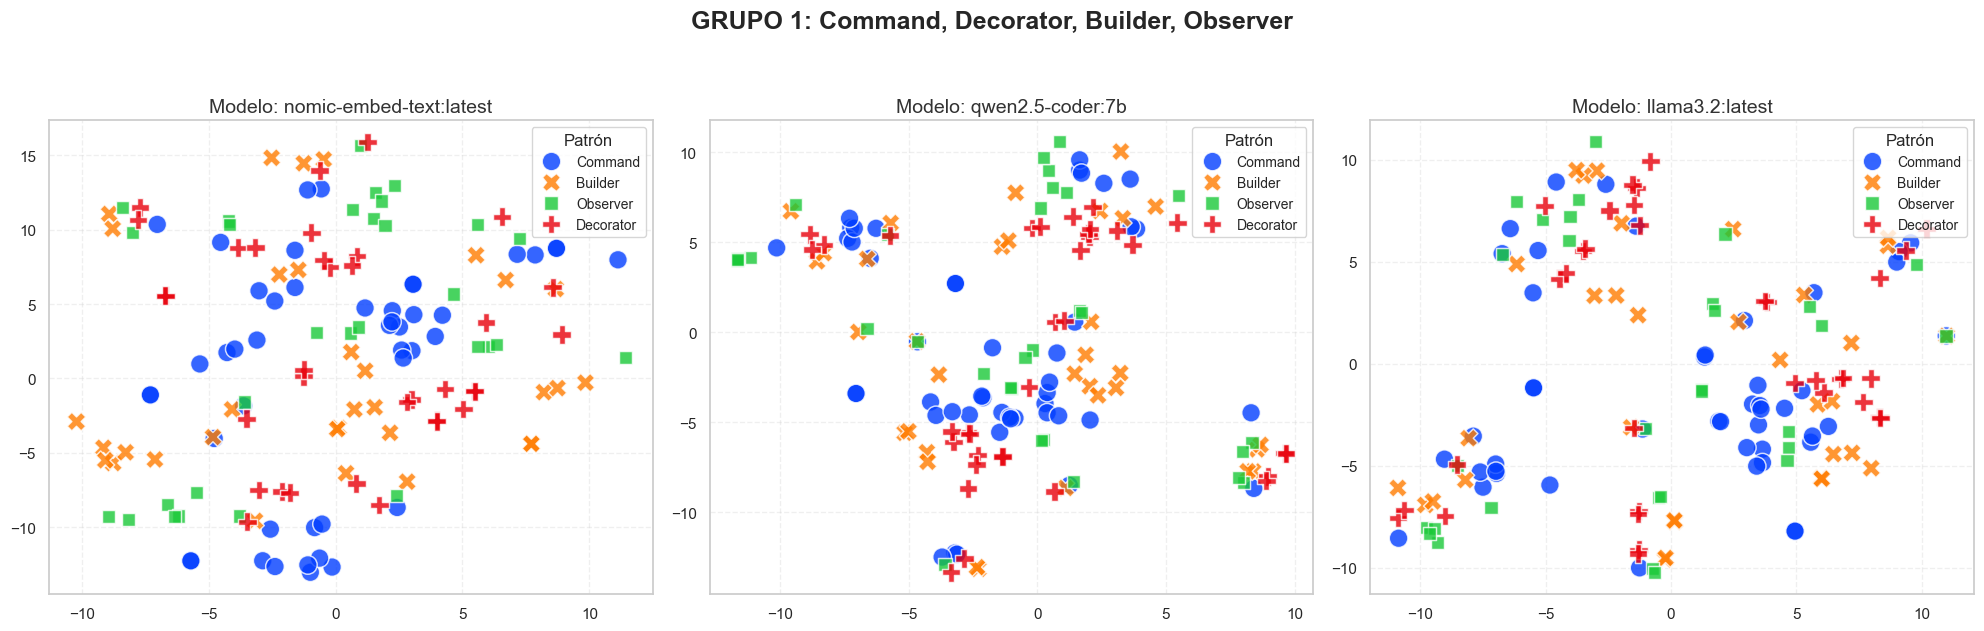

----------------------------------------------------------------------------------------------------


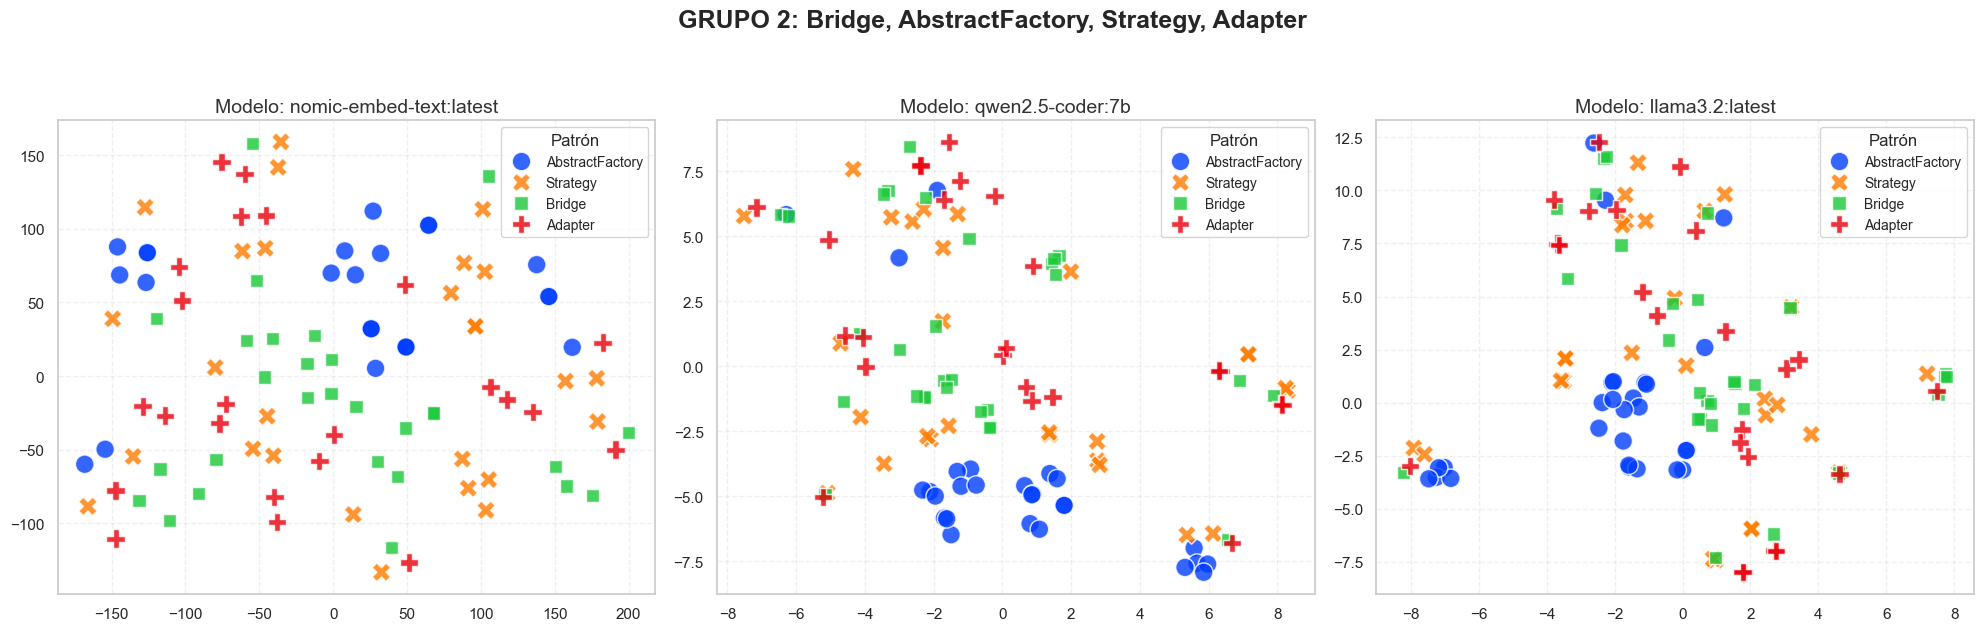

----------------------------------------------------------------------------------------------------


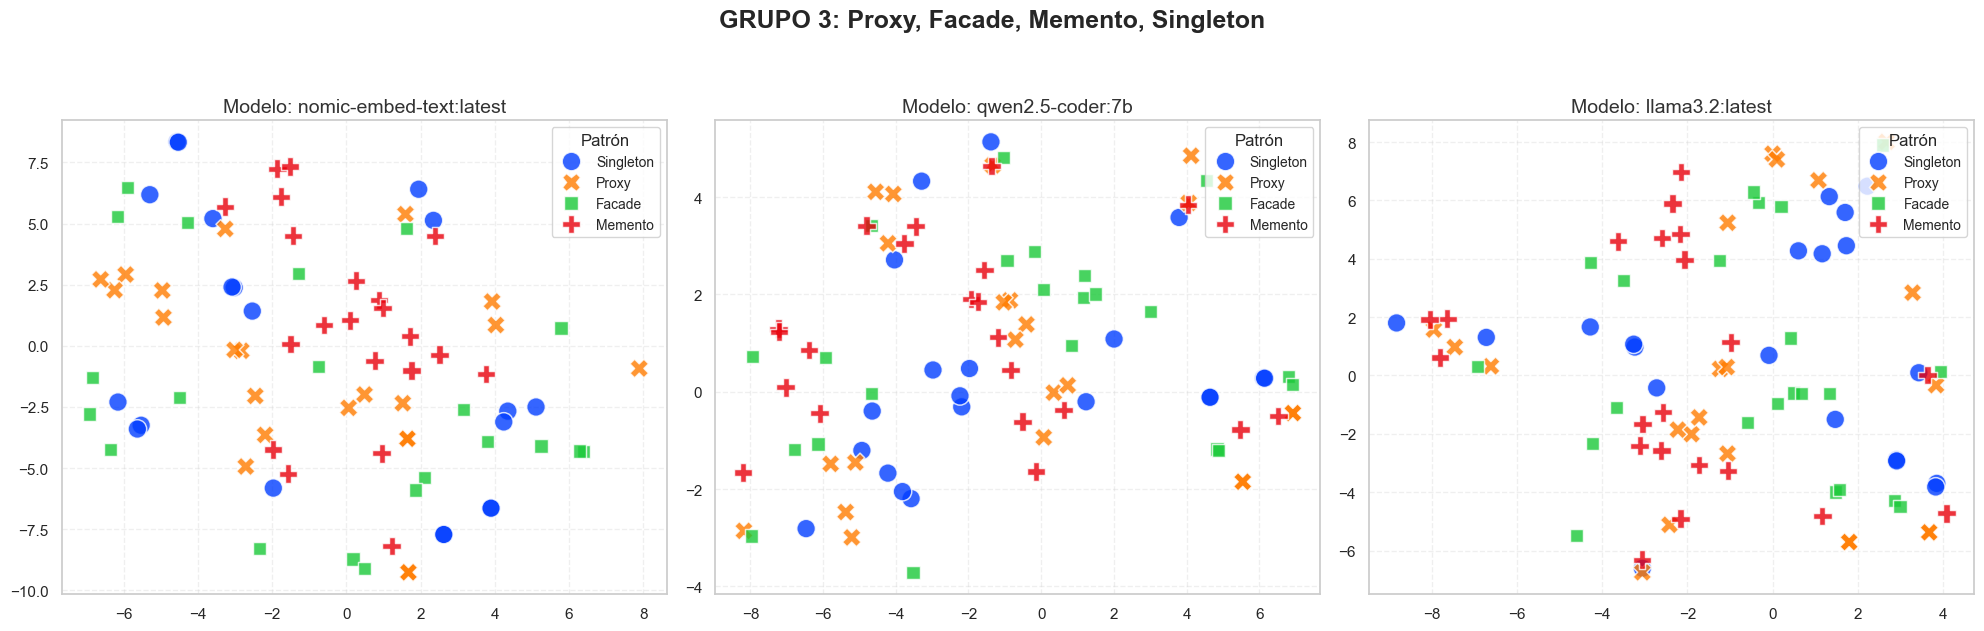

----------------------------------------------------------------------------------------------------


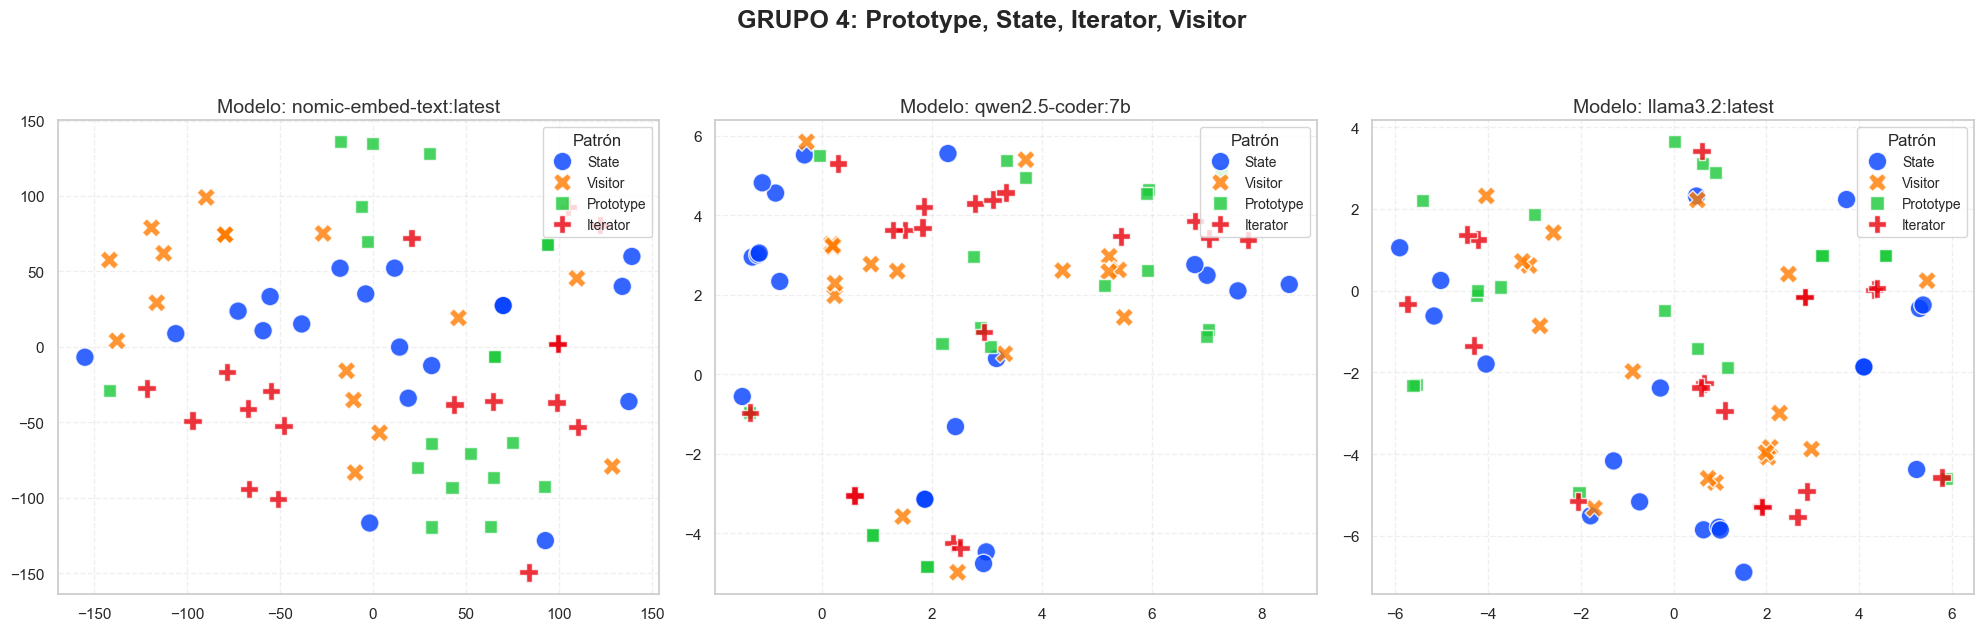

----------------------------------------------------------------------------------------------------


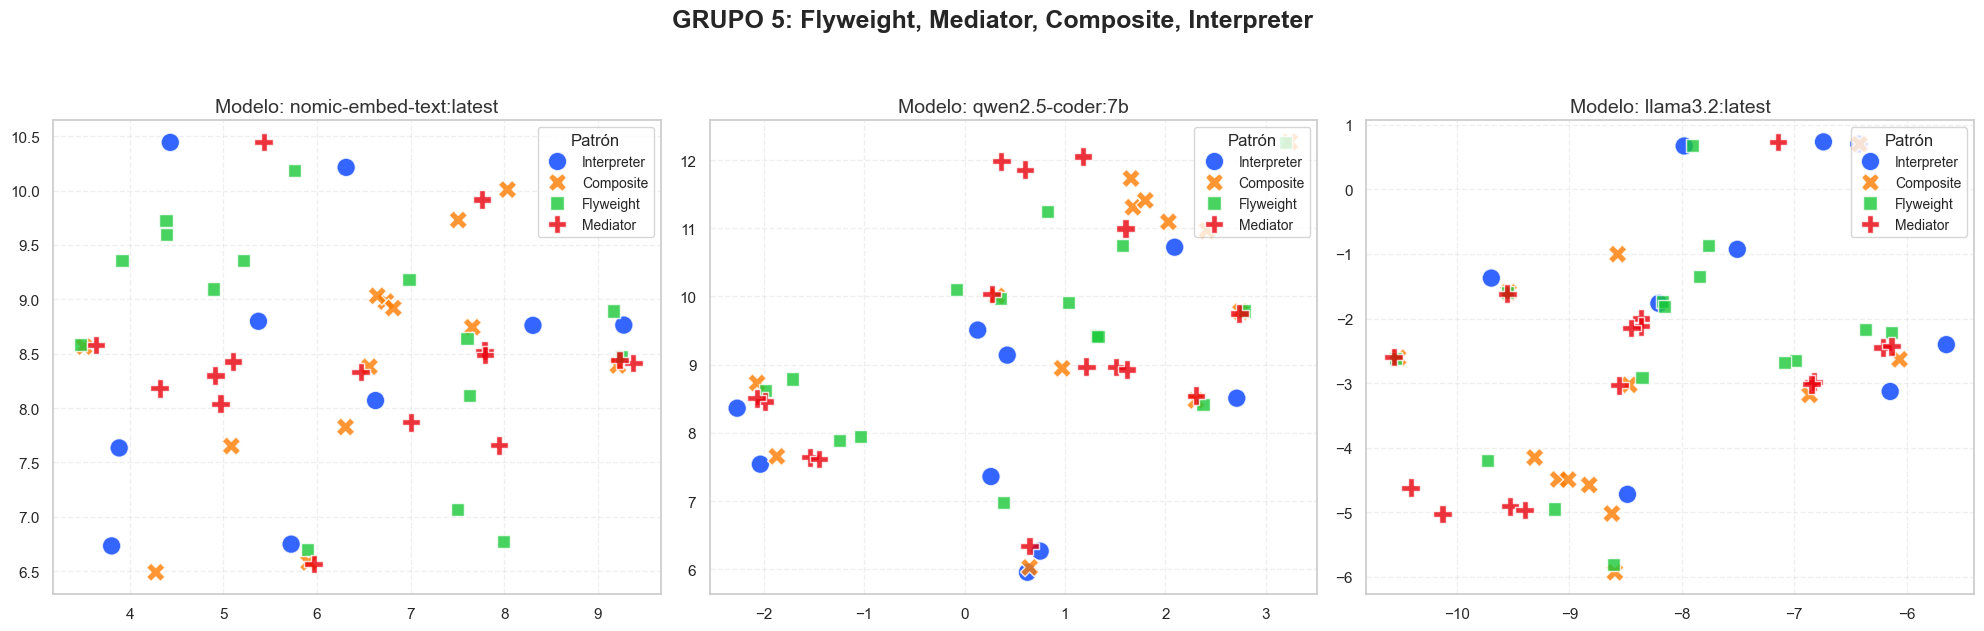

----------------------------------------------------------------------------------------------------


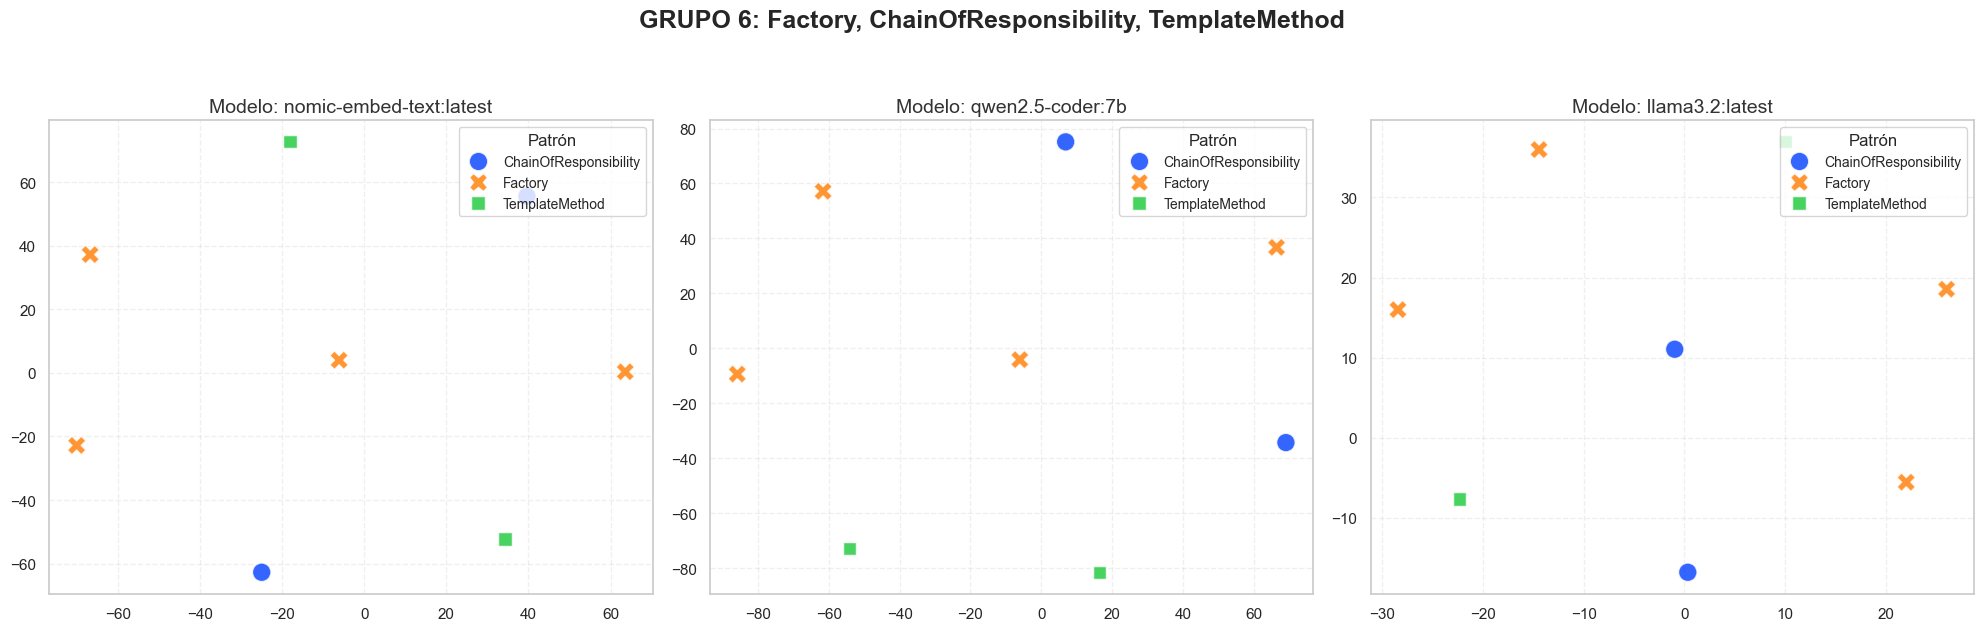

----------------------------------------------------------------------------------------------------


In [13]:
# Celda 8: Visualización por Grupos (4 Patrones por Fila - Figuras Independientes)
import math
from collections import Counter

# 1. Contar frecuencia y ordenar patrones (Mayor a Menor)
# Usamos el primer modelo para obtener las etiquetas
first_model = list(models_data.keys())[0]
y_all_indices = models_data[first_model]['y']
y_all_names = class_names[y_all_indices]

counts = Counter(y_all_names)
sorted_patterns = sorted(class_names, key=lambda x: counts[x], reverse=True)

print("📉 Orden de Patrones (por frecuencia):")
for p in sorted_patterns:
    print(f"   - {p}: {counts[p]} archivos")

# Configuración
PATTERNS_PER_GROUP = 4
model_names = list(models_data.keys())

print(f"\n🖼️ Generando visualizaciones (Grupos de {PATTERNS_PER_GROUP} patrones)...\n")

# 2. Bucle Principal: Iterar por grupos de patrones
for group_idx, chunk_start in enumerate(range(0, len(sorted_patterns), PATTERNS_PER_GROUP)):
    
    # Identificar qué patrones tocan en este grupo
    current_patterns = sorted_patterns[chunk_start : chunk_start + PATTERNS_PER_GROUP]
    target_indices = [list(class_names).index(p) for p in current_patterns]
    
    # Crear una FIGURA nueva para este grupo (1 fila, 3 columnas para los modelos)
    fig, axes = plt.subplots(nrows=1, ncols=len(model_names), figsize=(20, 6))
    
    # Título general de la Figura (El grupo de patrones)
    group_title = ", ".join(current_patterns)
    fig.suptitle(f"GRUPO {group_idx + 1}: {group_title}", fontsize=18, fontweight='bold', y=1.05)
    
    # Asegurar que axes sea iterable aunque solo haya 1 modelo
    if len(model_names) == 1: axes = [axes]
    
    # 3. Bucle de Modelos: Graficar cada uno en su columna
    for col_idx, model_name in enumerate(model_names):
        ax = axes[col_idx]
        
        # Filtrar datos: Solo vectores de los patrones actuales
        data = models_data[model_name]
        mask = np.isin(data['y'], target_indices)
        
        X_subset = data['X'][mask]
        y_subset = data['y'][mask]
        
        # Validación de seguridad (por si hay muy pocos datos)
        if len(X_subset) < 2:
            ax.text(0.5, 0.5, "Datos insuficientes (<2)", ha='center', va='center')
            ax.set_title(model_name)
            continue
            
        # Calcular t-SNE específico para este subgrupo (Zoom local)
        perp = min(30, len(X_subset) - 1)
        tsne_local = TSNE(n_components=2, random_state=42, perplexity=perp, init='pca', learning_rate='auto')
        X_embedded = tsne_local.fit_transform(X_subset)
        
        # DataFrame temporal para Seaborn
        df_subset = pd.DataFrame(X_embedded, columns=['x', 'y'])
        df_subset['Patrón'] = class_names[y_subset]
        
        # Graficar
        sns.scatterplot(
            data=df_subset, x='x', y='y', 
            hue='Patrón', style='Patrón', 
            palette='bright', s=180, ax=ax, alpha=0.8
        )
        
        # Estética
        ax.set_title(f"Modelo: {model_name}", fontsize=14, color='#333333')
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.legend(loc='upper right', fontsize='small', title="Patrón")
        ax.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show() # Muestra la figura completa de este grupo y pasa al siguiente
    print("-" * 100) # Separador visual en el output